In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range
import time
from scipy.special import logsumexp
from scipy.stats import truncnorm
import h5py

import brutus

# plot in-line within the notebook
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [6]:
# import MIST models
from brutus import filters
filters = filters.ps + filters.tmass
version_mist = 'v4.1'
filepath = '../data/grid_' + version_mist + '.h5'
models_mist, labels_mist, lmask_mist = brutus.load_models(filepath, filters=filters)
Nmodels_mist, Nbands_mist, Ncoef_mist = models.shape

Reading filter 2MASS_Ks           


In [7]:
# import Bayestar models
version_bs = 'v1'
filepath = '../data/grid_bayestar_' + version_bs + '.h5'
models_bs, labels_bs, lmask_bs = brutus.load_models(filepath, filters=filters)
Nmodels_bs, Nbands_bs, Ncoef_bs = models_bs.shape

Reading filter 2MASS_Ks           


In [8]:
# load in data
from frankenz.pdf import inv_magnitude
filename = '../data/Cam_146.7_17.7'
f = h5py.File(filename+'.h5')
fpix = f['photometry']['pixel 1024-12345']
mag, magerr = fpix['mag'], fpix['err']
mask = np.isfinite(magerr)  # band mask
mag[~mask], magerr[~mask] = 0., 1.  # deal with missing data
phot, err = inv_magnitude(mag, magerr)  # convert assuming AB zero-point
objid = fpix['obj_id']
parallax, parallax_err = fpix['parallax'] * 1e3, fpix['parallax_error'] * 1e3  # convert to mas
psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = np.c_[fpix['l'], fpix['b']]

Nobjs = len(phot)

In [11]:
# parallel computing
import ipyparallel as ipp

# check cores
# note that these include virtual cores
rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

# switch to dill for robustness
dview = rc[:]
dview.use_dill();

# define pool
class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

[0, 1, 2, 3, 4, 5, 6, 7]


In [12]:
%%px

# import environment
from __future__ import print_function, division
import sys, os
import numpy as np
import scipy
from six.moves import range
import h5py
import brutus


# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:', os.getpid())

[stdout:0] Random seed: 31776
[stdout:1] Random seed: 31778
[stdout:2] Random seed: 31780
[stdout:3] Random seed: 31782
[stdout:4] Random seed: 31786
[stdout:5] Random seed: 31805
[stdout:6] Random seed: 31796
[stdout:7] Random seed: 31817


In [13]:
# initialize our pool
pool = Pool(dview)

In [14]:
# load in fitter
from brutus.fitting import BruteForce
BF_bs = BruteForce(models_bs, labels_bs, lmask_bs, pool=pool)
BF_mist = BruteForce(models_mist, labels_mist, lmask_mist, pool=pool)

In [19]:
# Bayestar
t1 = time.time()
BF_bs.fit(phot, err, mask, objid, 
          filename+'_bayestar_'+version_bs,
          parallax=parallax, parallax_err=parallax_err,
          data_coords=coords, apply_agewt=False)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

Fitting object 1387/1387


Avg time per object: 0.796087671203


In [20]:
# MIST
t1 = time.time()
BF_mist.fit(phot, err, mask, objid, 
            filename+'_mist_'+version_mist,
            parallax=parallax, parallax_err=parallax_err, 
            data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

Fitting object 1387/1387


Avg time per object: 3.22964291927


In [22]:
# load Bayestar results
f = h5py.File(filename+'_bayestar_'+version_bs+'.h5')
s_bs = f['scales'][:]
av_bs = f['avs'][:]
cov_bs = f['cov_sa'][:]
idxs_bs = f['idxs'][:]
chi2_bs = f['best_chi2'][:]
levid_bs = f['log_evidence'][:]
nbands_bs = f['Nbands'][:]
dists_bs = f['dists'][:]
reds_bs = f['reds'][:]

In [23]:
# load MIST results
f = h5py.File(filename+'_mist_'+version_mist+'.h5')
s_mist = f['scales'][:]
av_mist = f['avs'][:]
cov_mist = f['cov_sa'][:]
idxs_mist = f['idxs'][:]
chi2_mist = f['best_chi2'][:]
levid_mist = f['log_evidence'][:]
nbands_mist = f['Nbands'][:]
dists_mist = f['dists'][:]
reds_mist = f['reds'][:]

Best-fit chi2: 9.03391


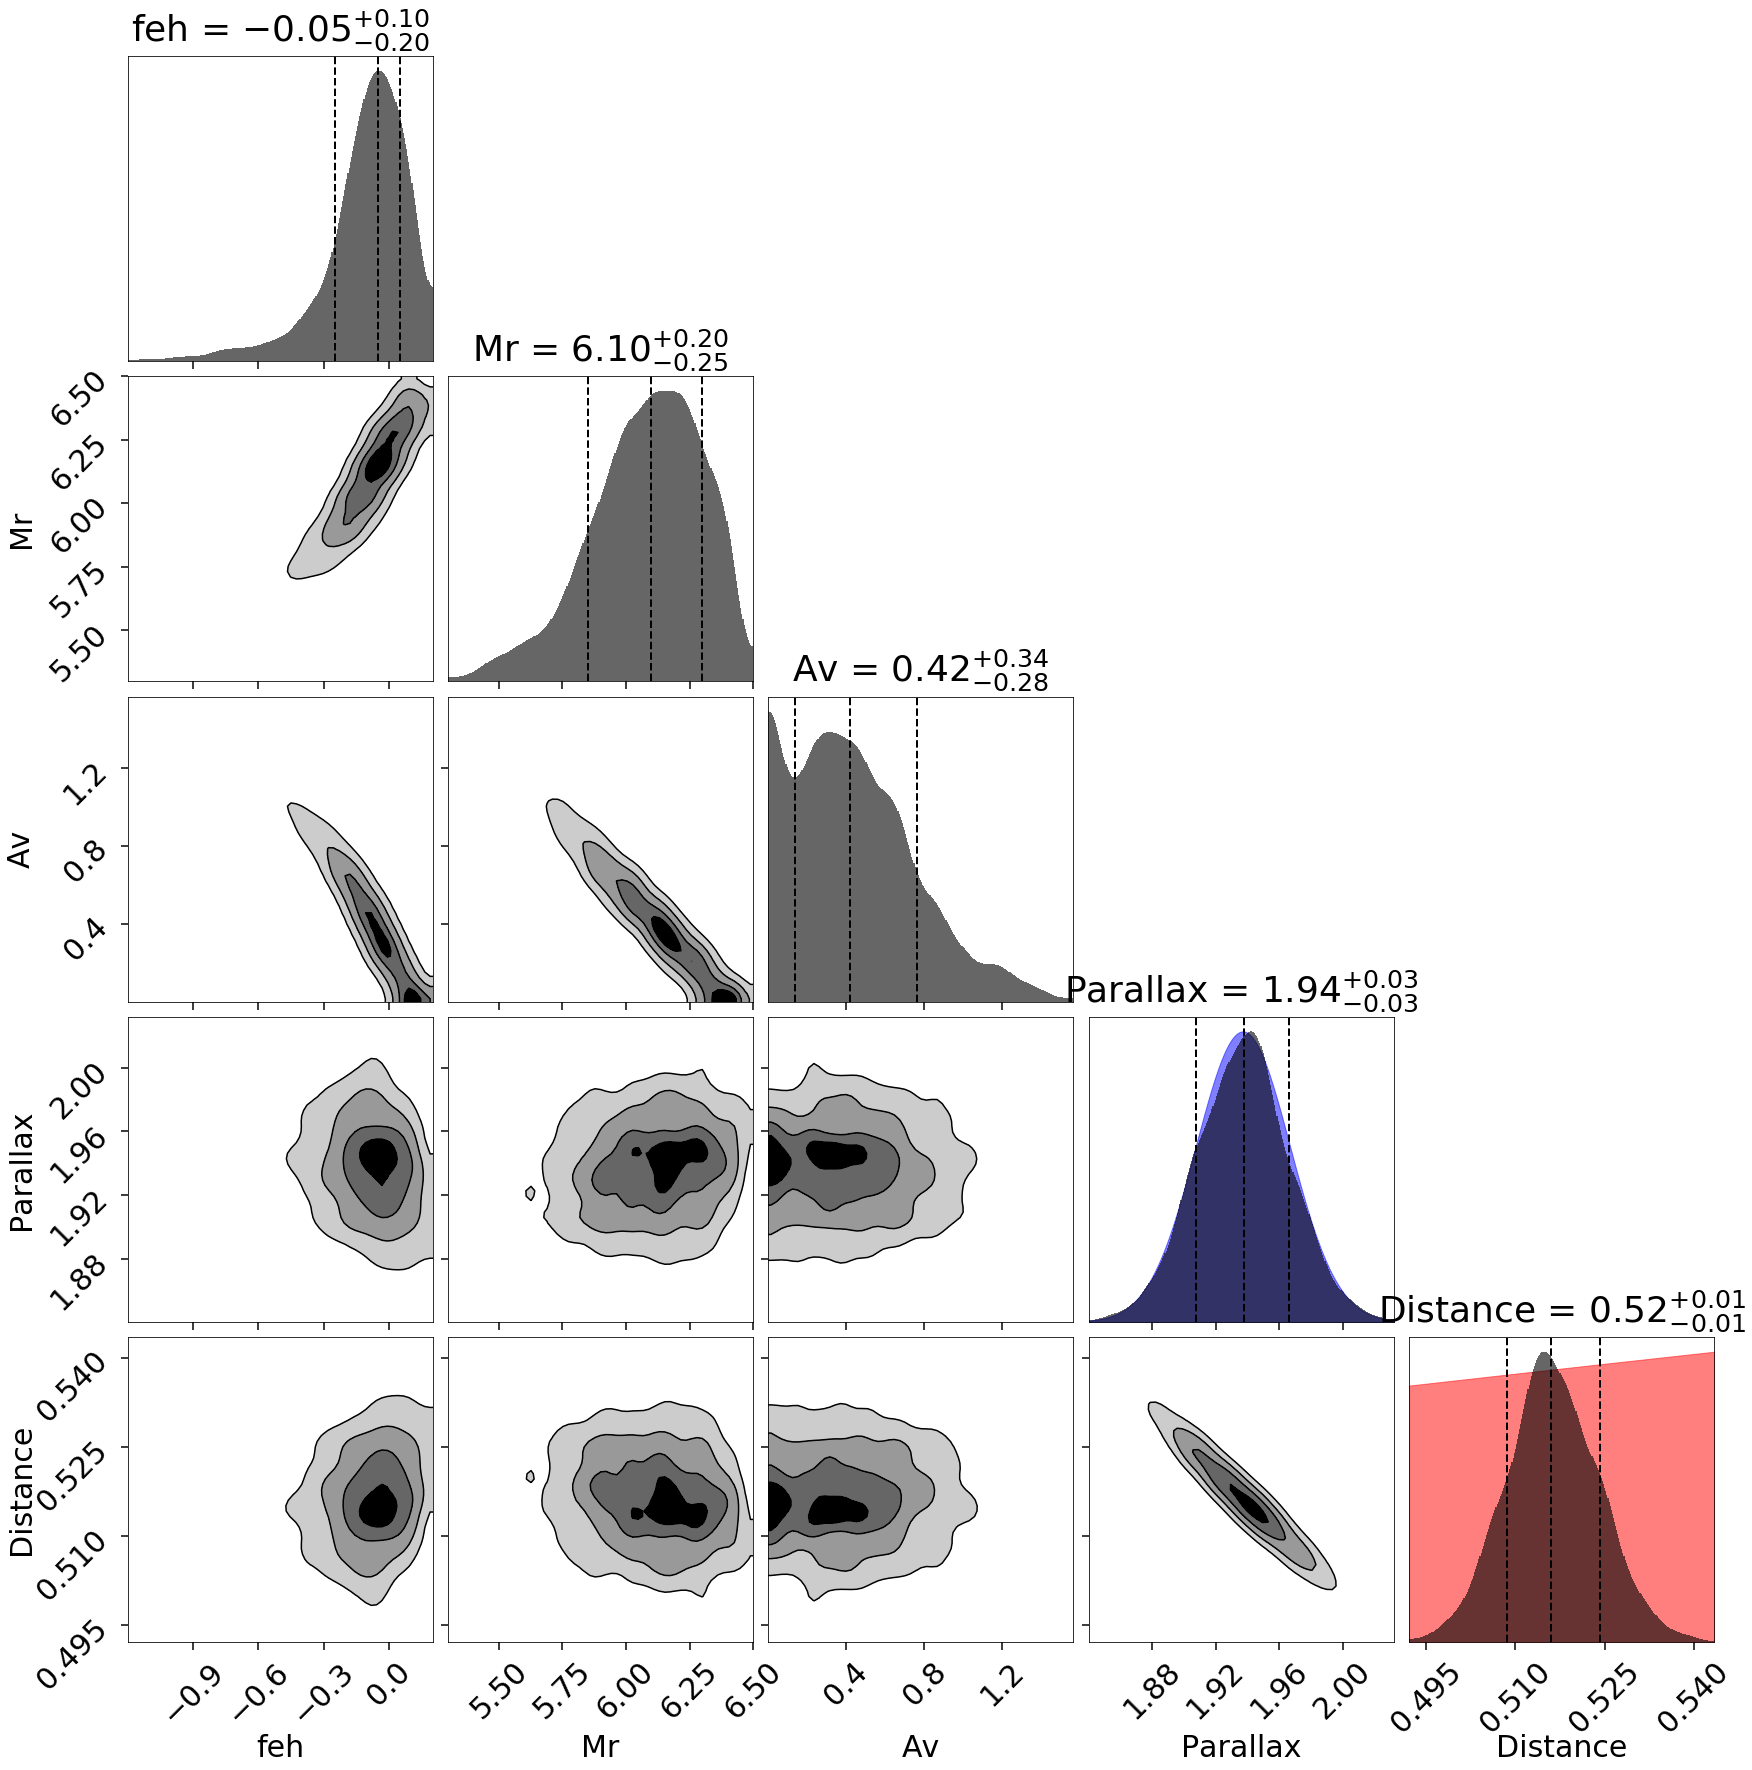

In [24]:
# plot snapshot of results
from brutus import plotting as bplot

i = 0

# Bayestar
print('Best-fit chi2:', chi2_bs[i])
fig, axes = bplot.cornerplot(idxs_bs[i], (dists_bs[i], reds_bs[i]),
                             labels_bs, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(5, 5, figsize=(25, 25)))

Best-fit chi2: 7.46304


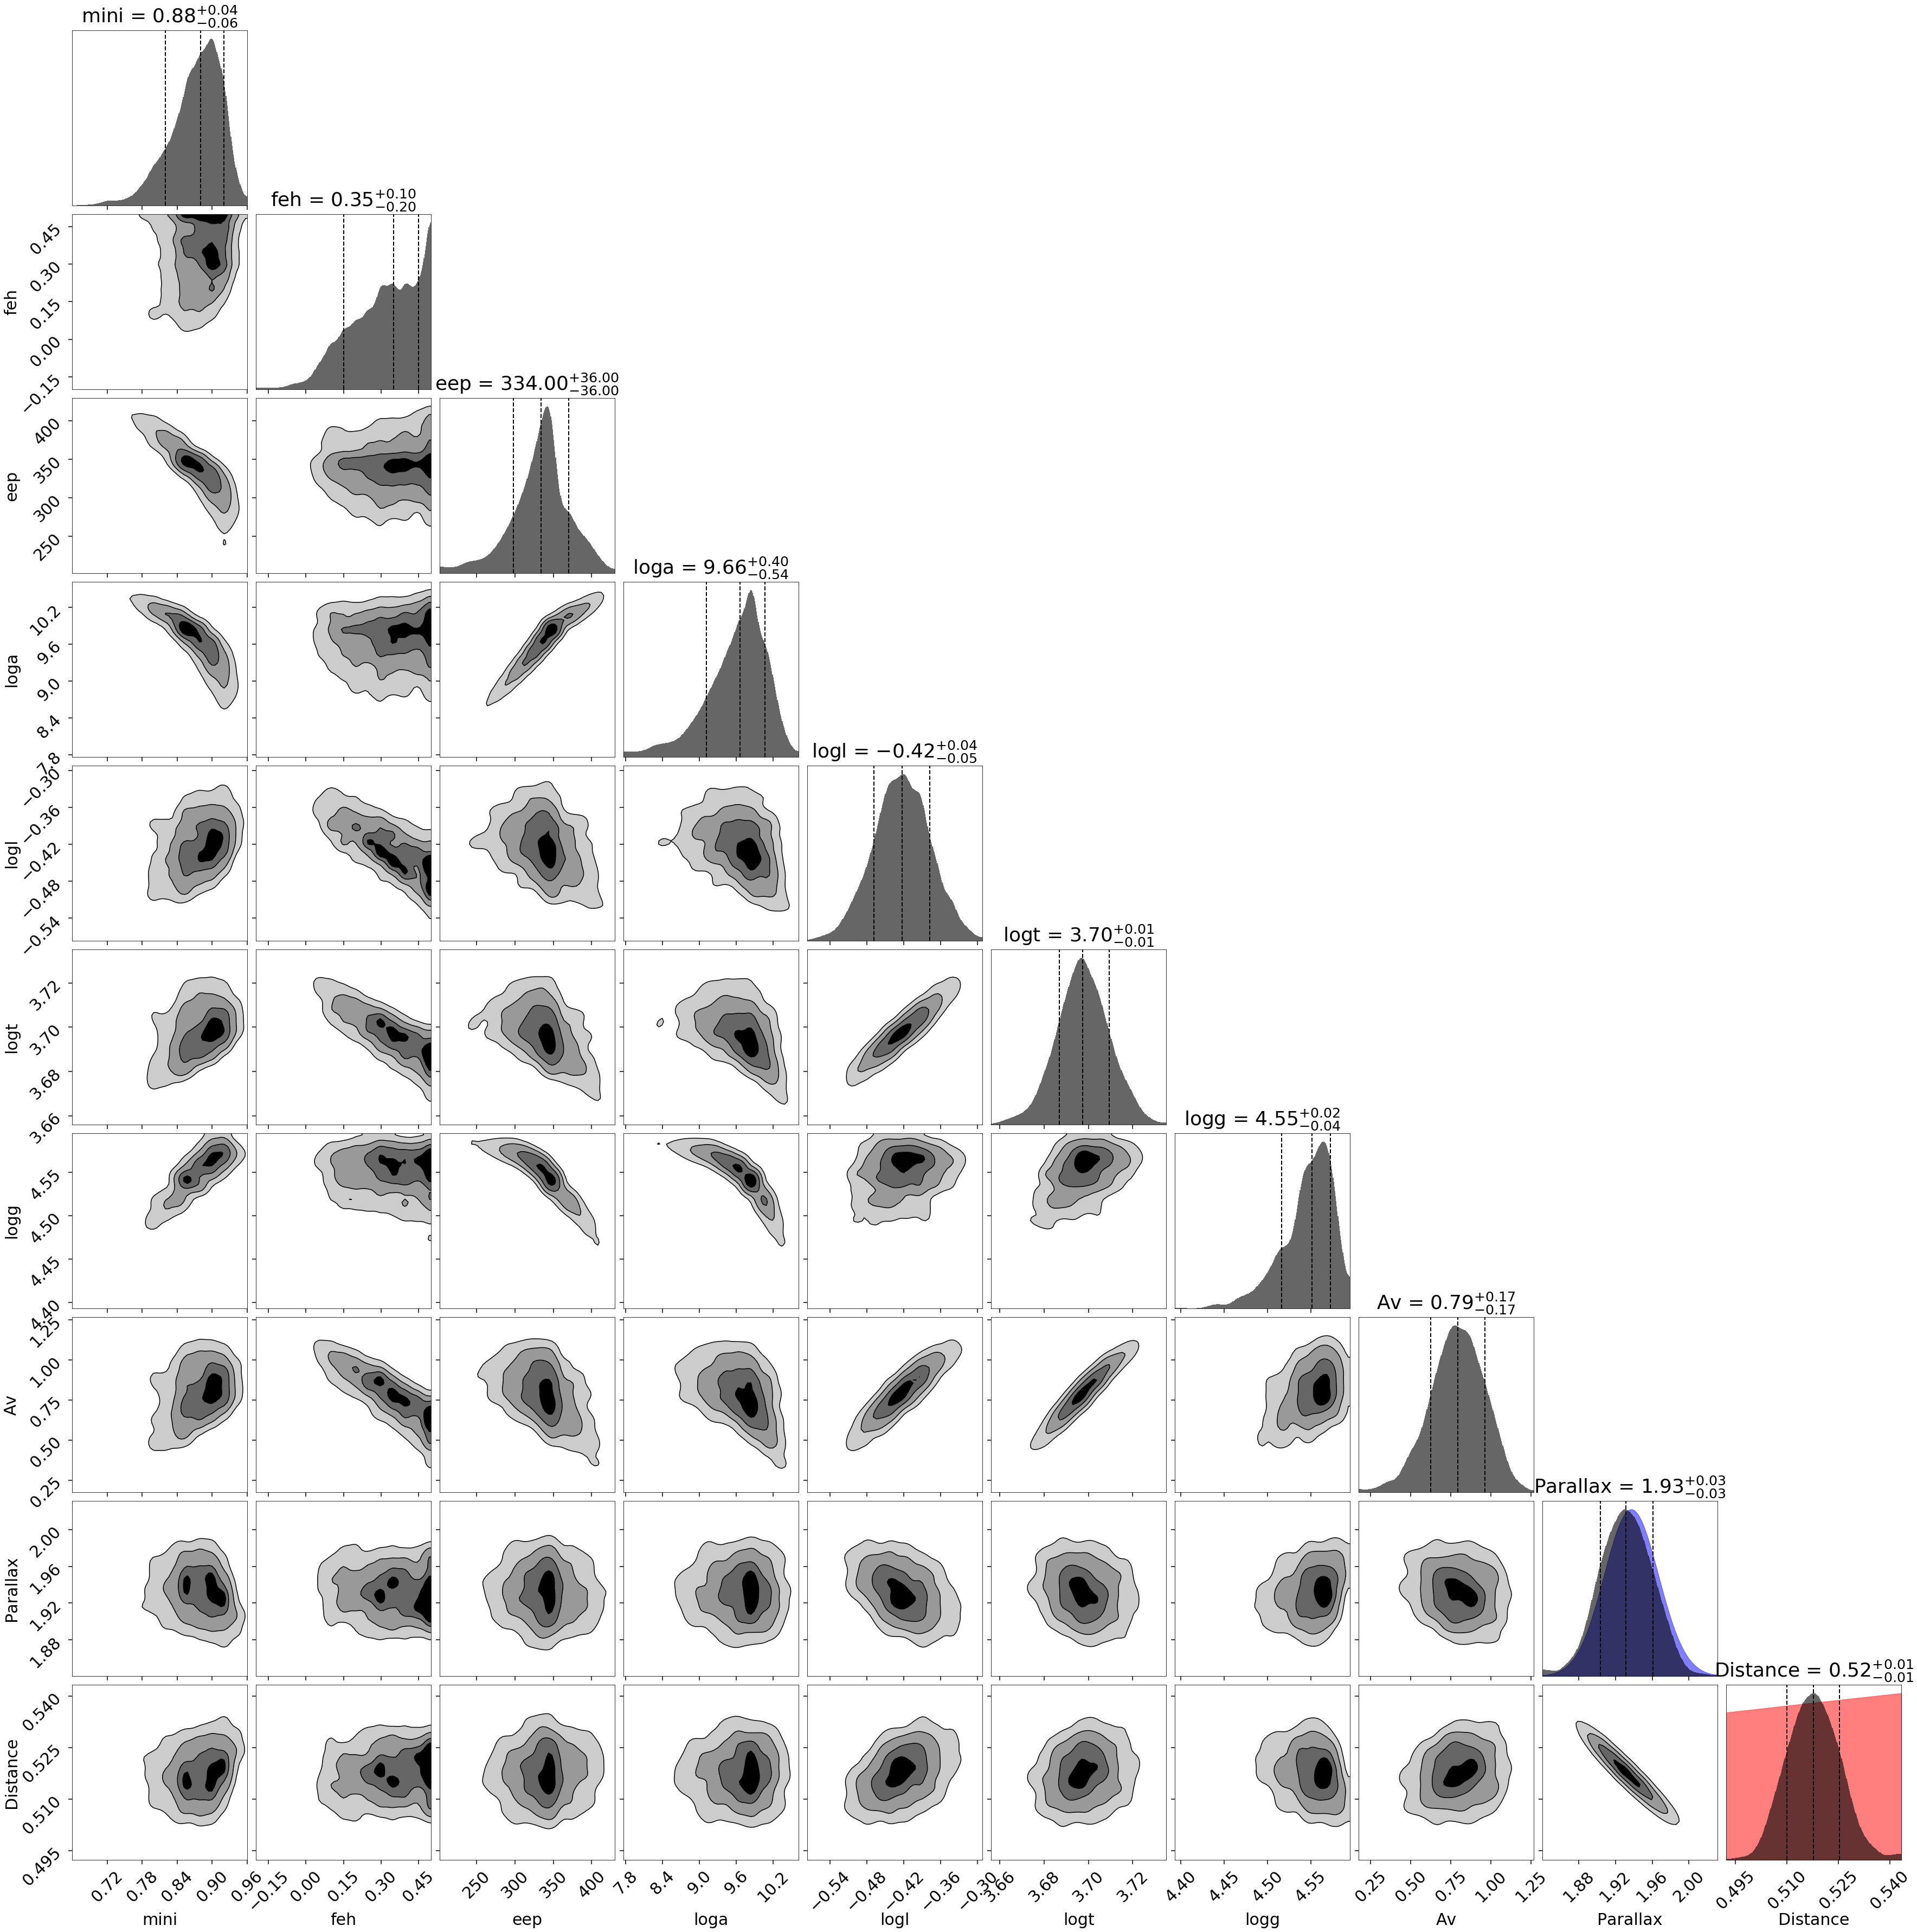

In [25]:
# MIST with gaia
print('Best-fit chi2:', chi2_mist[i])
fig, axes = bplot.cornerplot(idxs_mist[i], (dists_mist[i], reds_mist[i]),
                             labels_mist, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))

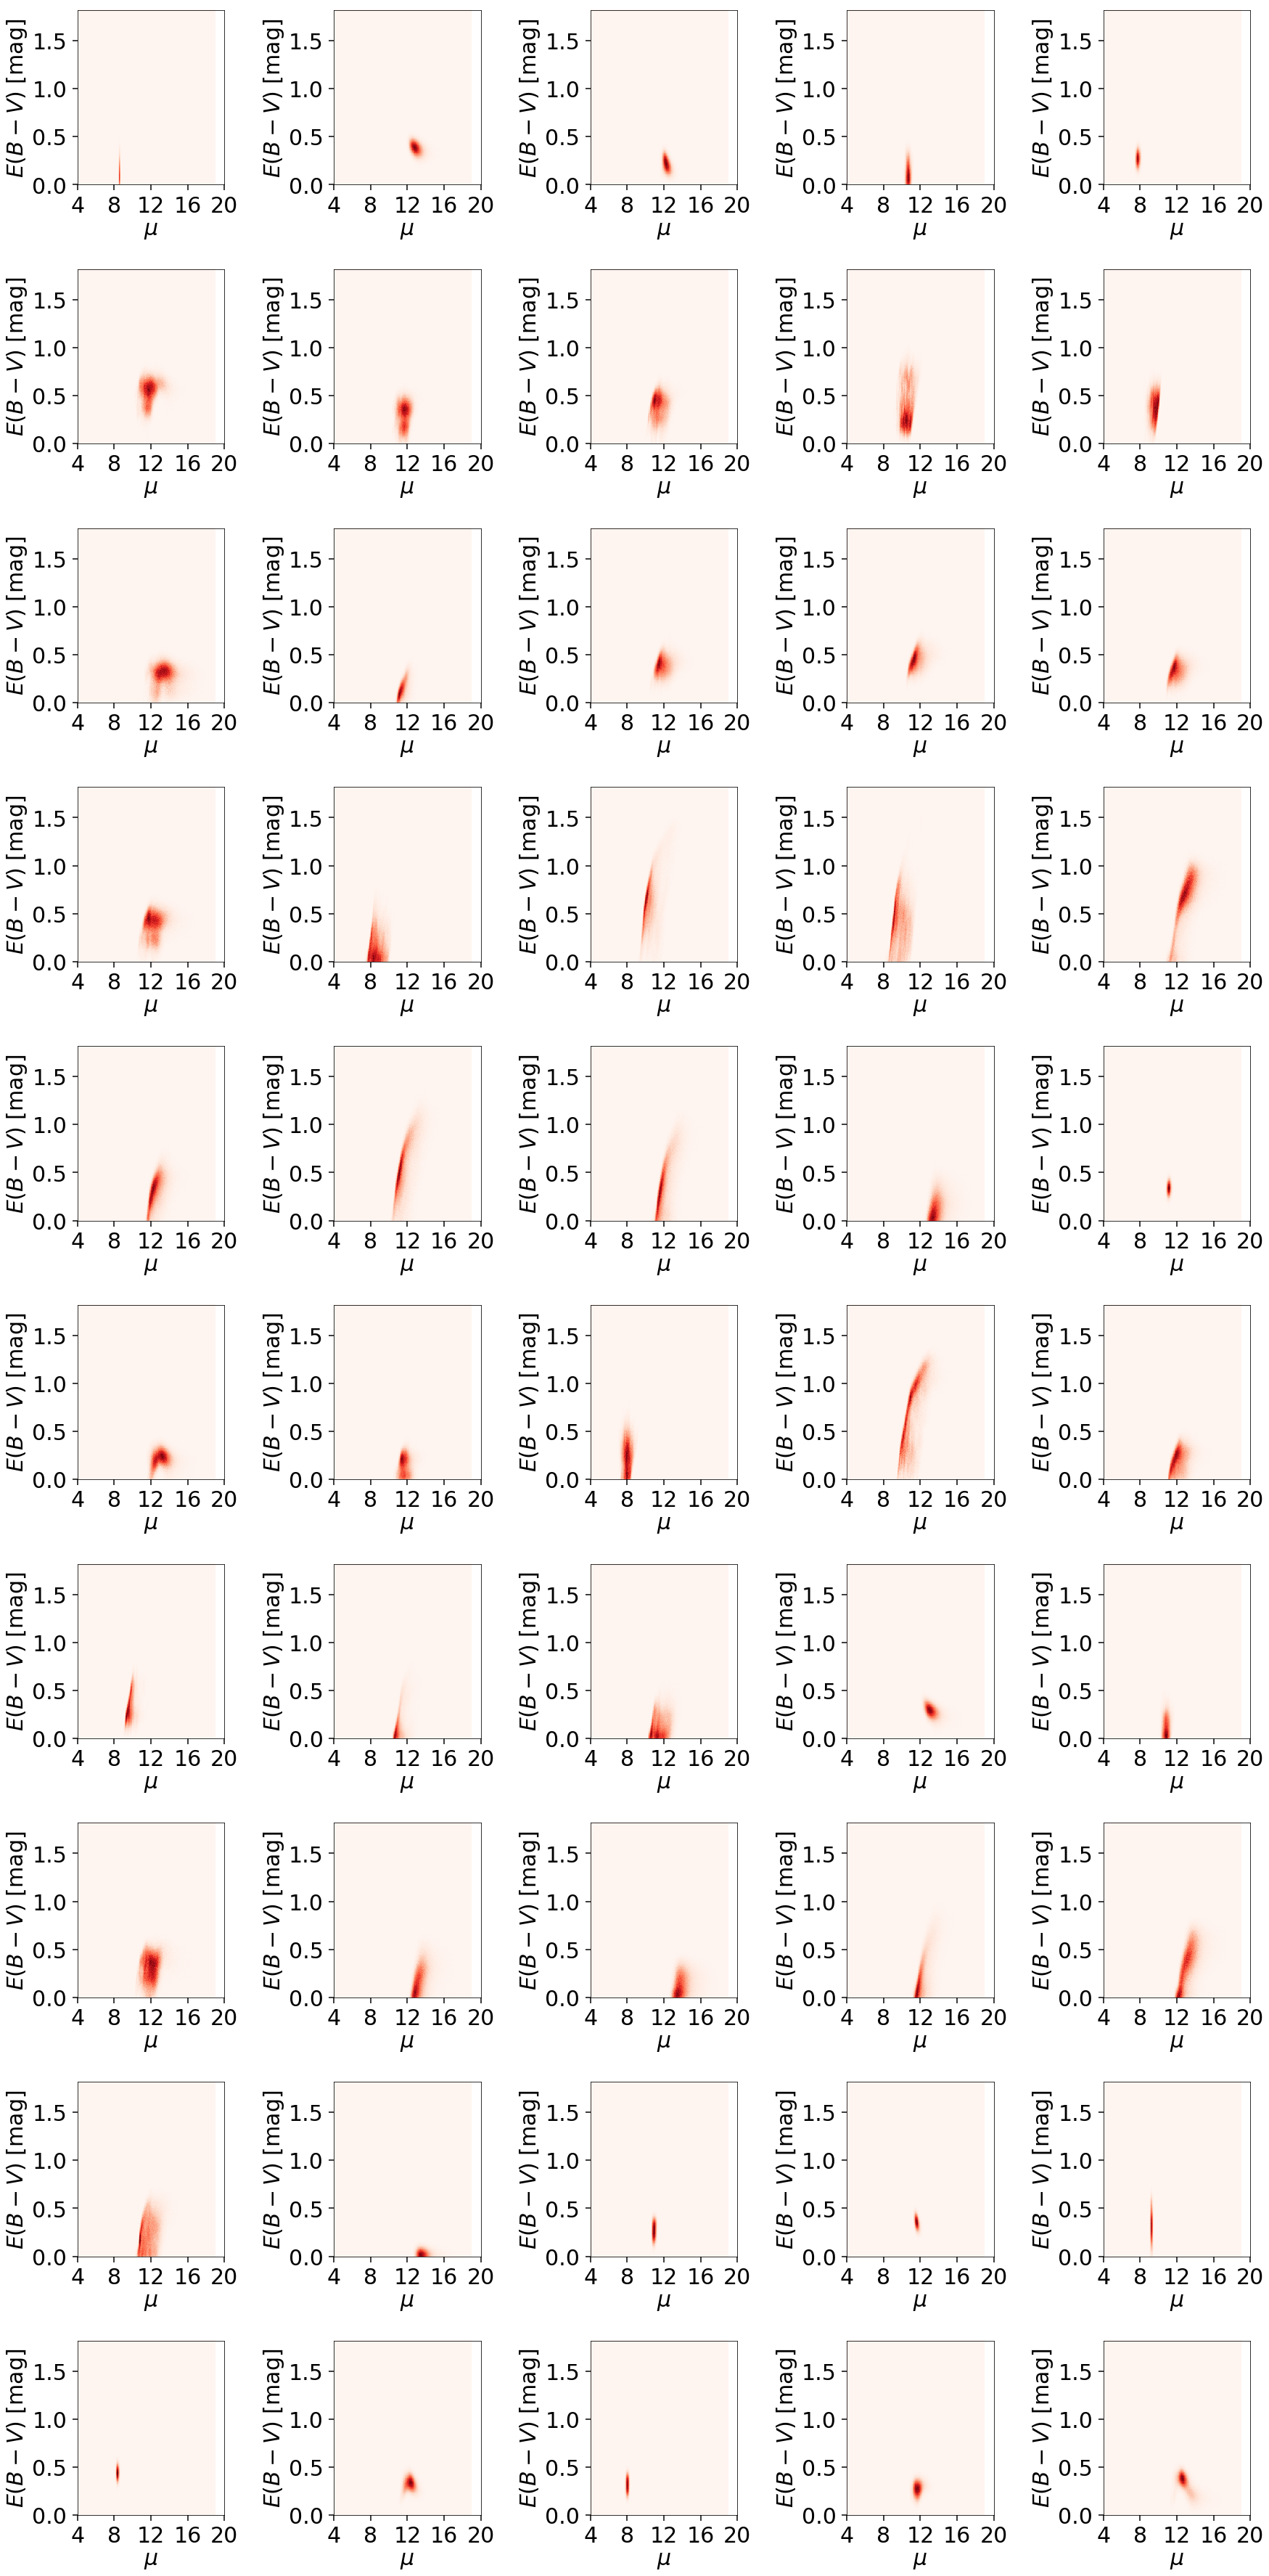

In [19]:
# Bayestar subset
xdim, ydim = 25, 50
plt.figure(figsize=(xdim, ydim))
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red(s_bs[i], av_bs[i], cov_bs[i], coord=coords[i],
                      cmap='Reds')
    plt.xticks(np.arange(4., 21., 4.))
    plt.yticks(np.arange(0., 2., 0.5))
plt.tight_layout()

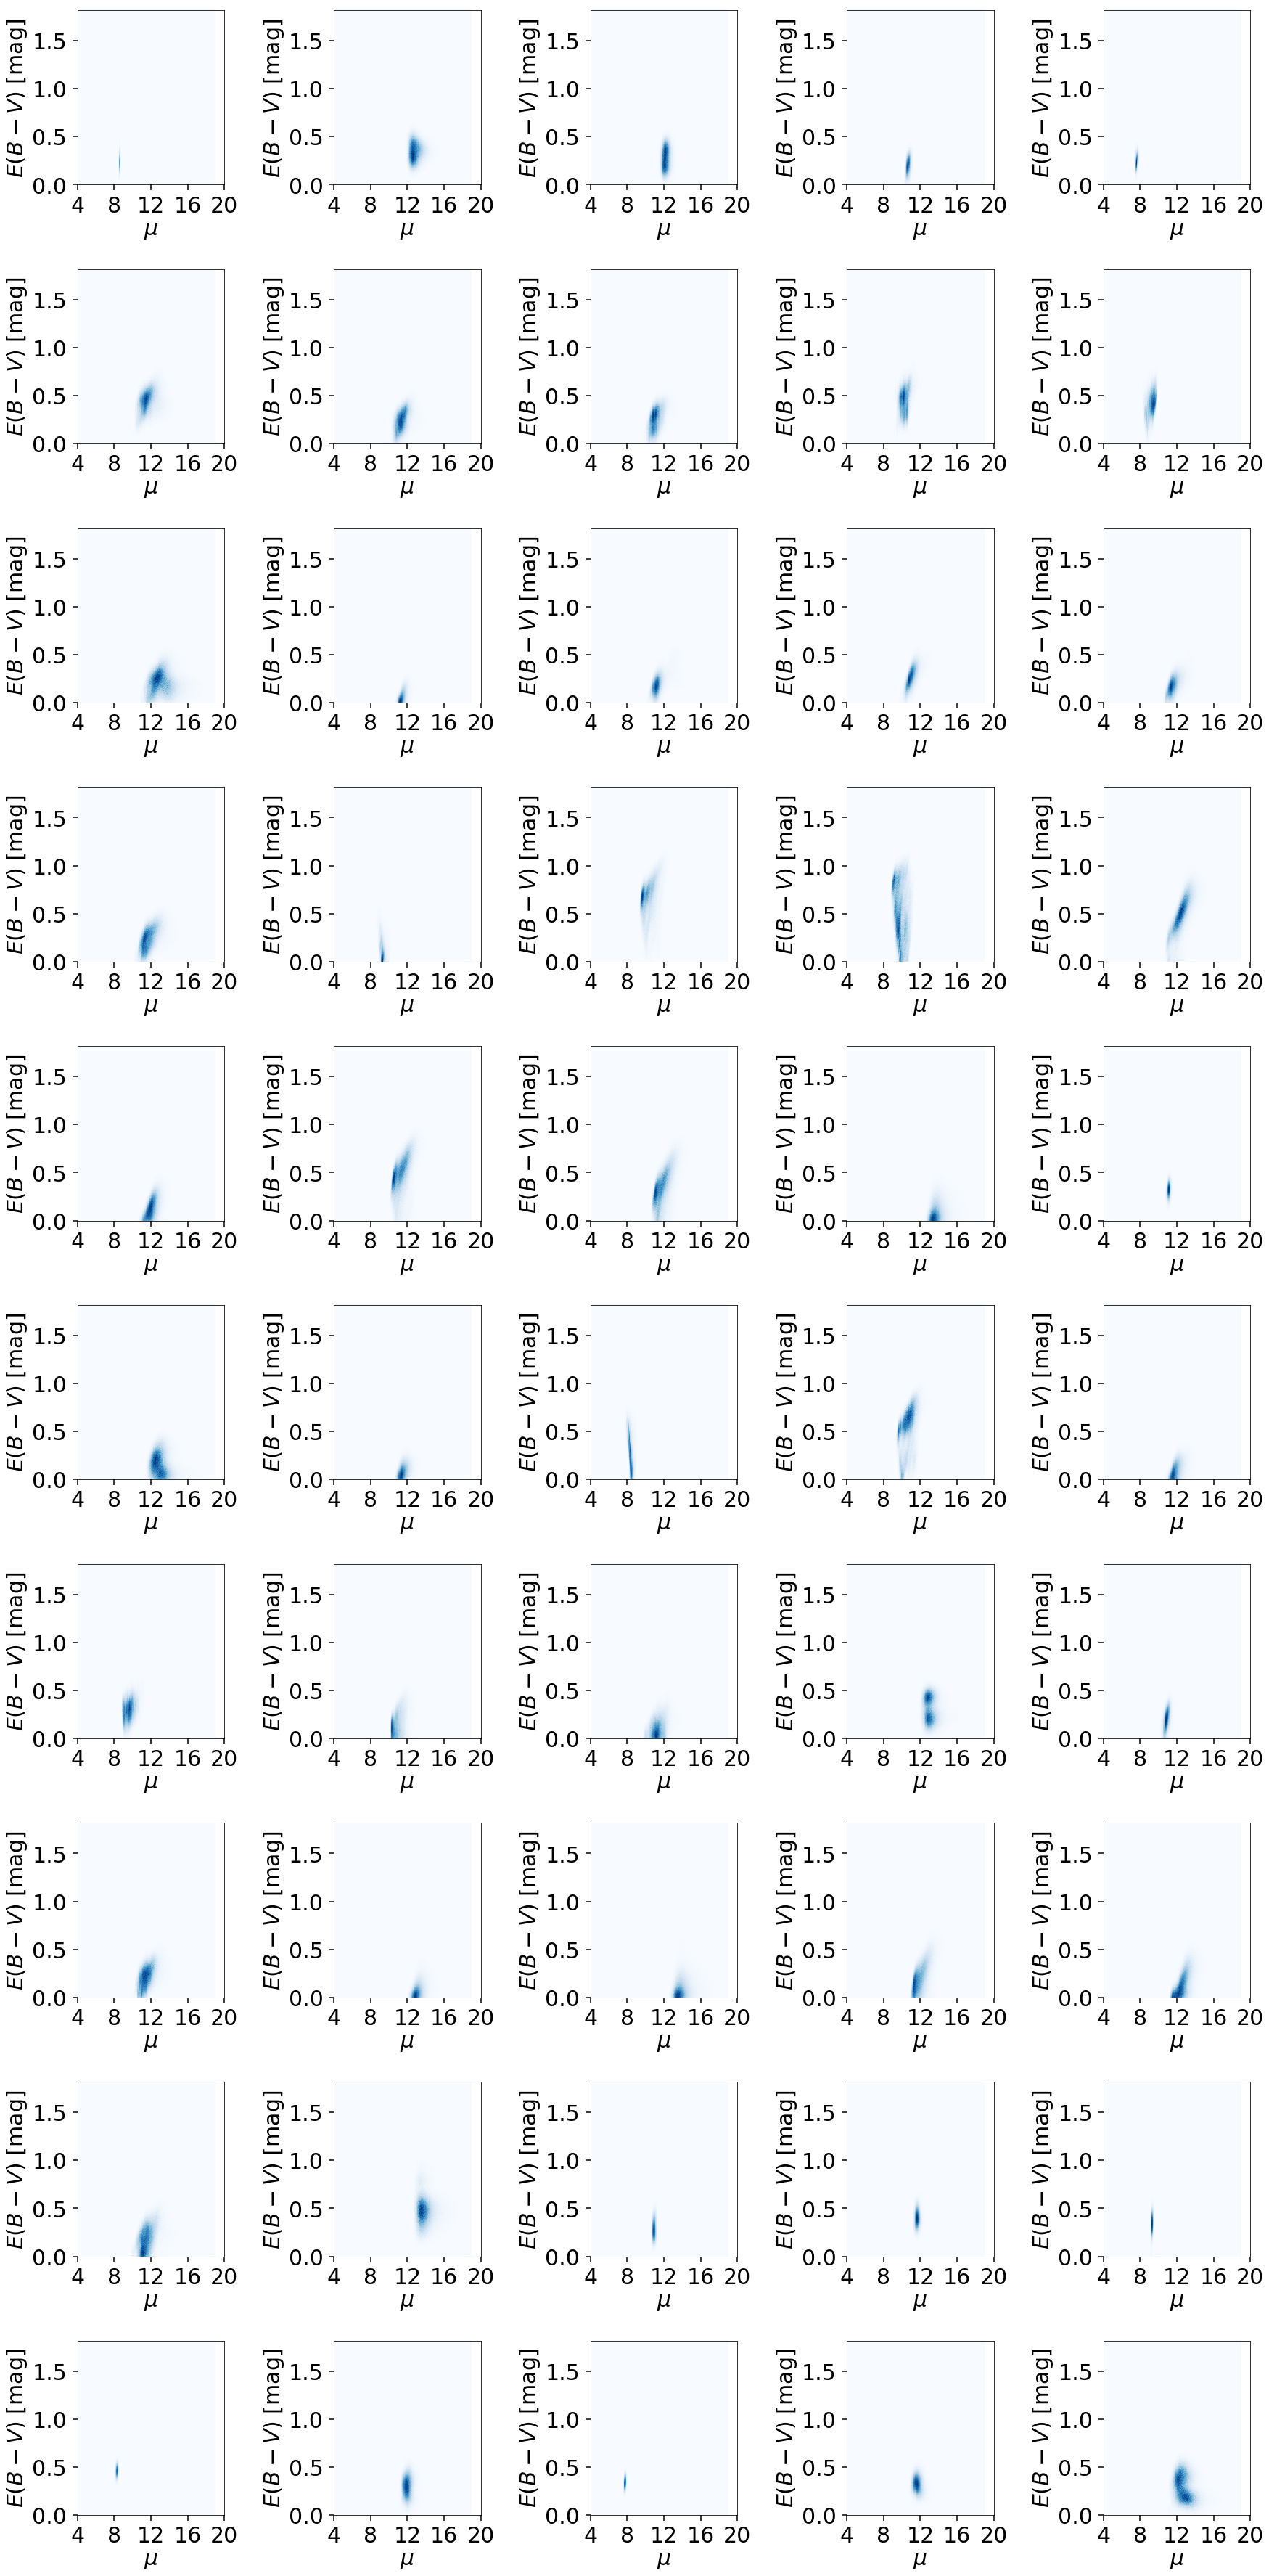

In [20]:
# MIST subset
xdim, ydim = 25, 50
plt.figure(figsize=(xdim, ydim))
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red(s_mist[i], av_mist[i], cov_mist[i], coord=coords[i],
                      cmap='Blues')
    plt.xticks(np.arange(4., 21., 4.))
    plt.yticks(np.arange(0., 2., 0.5))
plt.tight_layout()

In [21]:
# generate binned CDFs (Bayestar)
(cdfbin_bs, xedges, yedges) = brutus.pdf.bin_pdfs_distred(s_bs, av_bs, cov_bs, 
                                                          coords=coords, cdf=True,
                                                          parallaxes=parallax,
                                                          parallax_errors=parallax_err)

Binning object 1387/1387

In [22]:
# fit dust along the LOS w/ dynesty
import dynesty

loglikelihood = brutus.fitting.LOSloglike
prior_transform = brutus.fitting.LOSpriortransform
nclouds = 1
ndim = 2 * (1 + nclouds)

sampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                       sample='rwalk', walks=25,
                                       update_interval=5.,
                                       logl_args=[cdfbin_bs, xedges, yedges])
sampler.run_nested()
results_bs = sampler.results

iter: 27229 | batch: 11 | bound: 216 | nc: 25 | ncall: 644574 | eff(%):  4.224 | loglstar: -7168.004 < -7161.089 < -7161.608 | logz: -7178.347 +/-  0.173 | stop:  0.832               


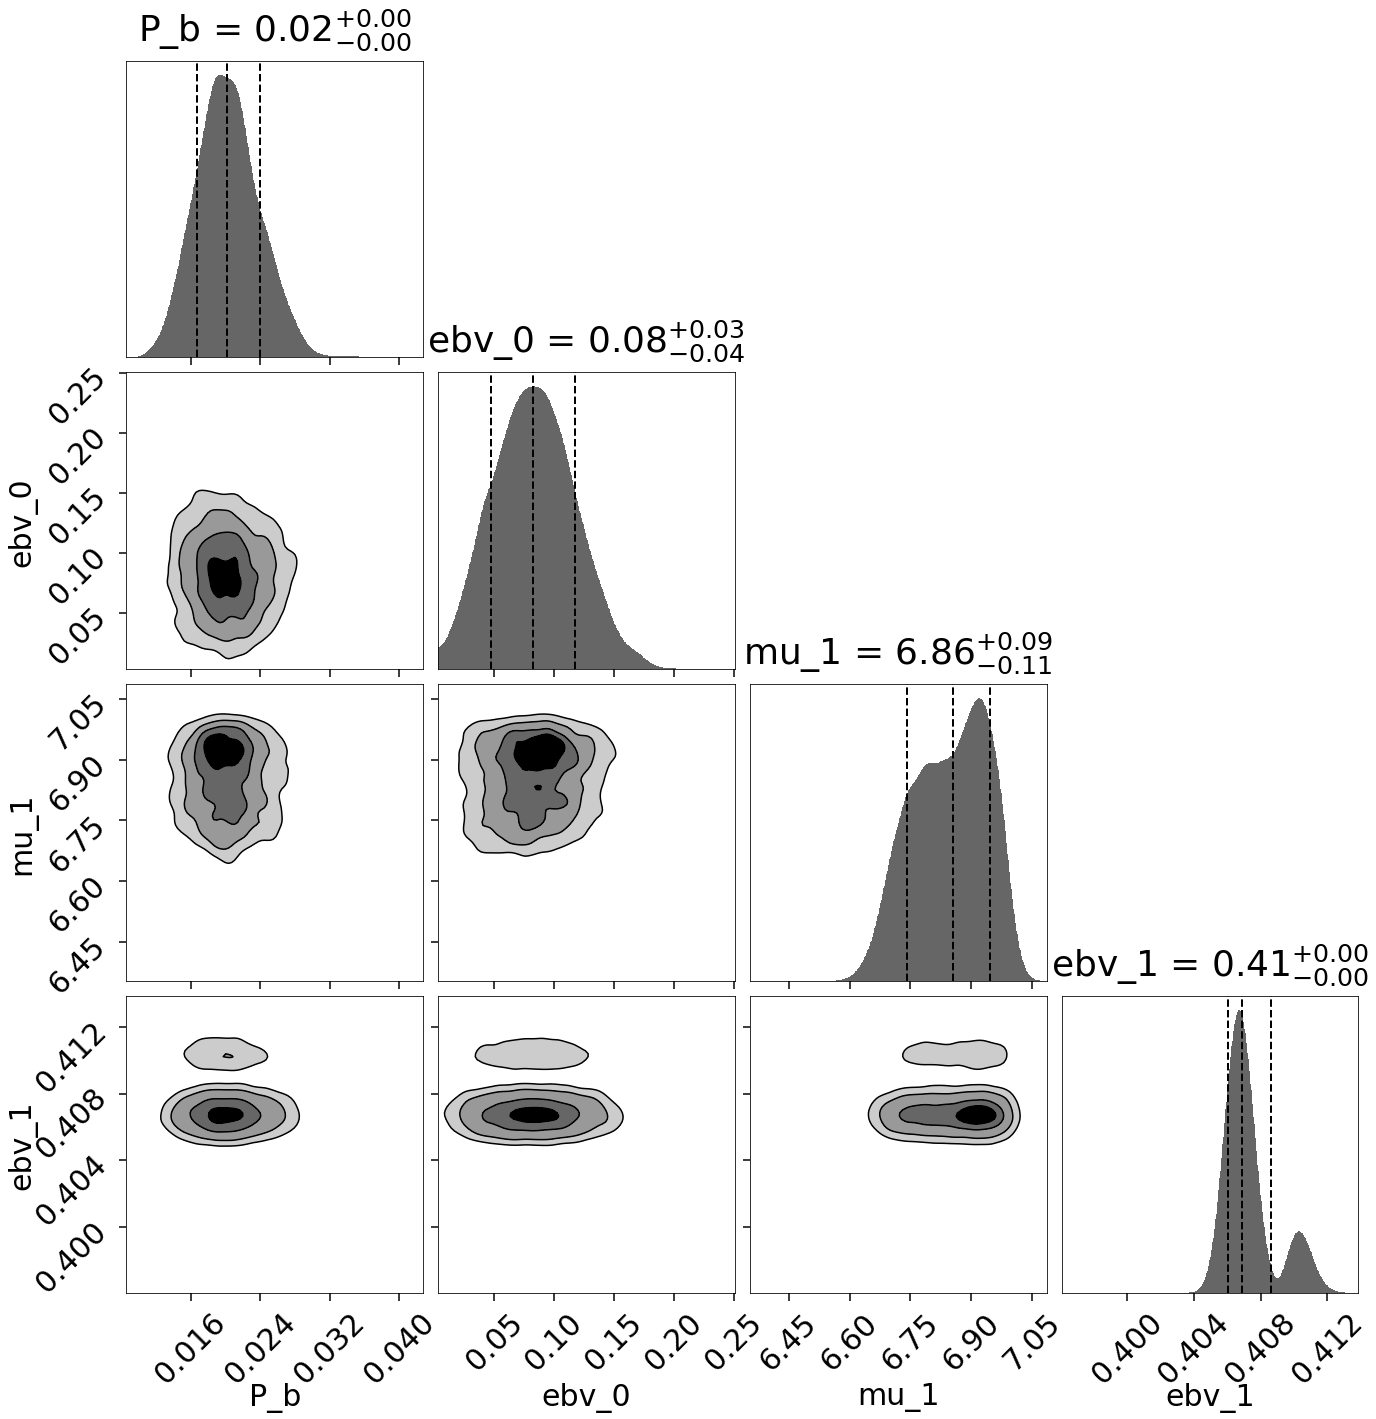

In [23]:
# plot results
from dynesty import plotting as dyplot

fig, ax = dyplot.cornerplot(results_bs, labels=['P_b', 'ebv_0', 'mu_1', 'ebv_1'],
                            show_titles=True, title_kwargs={'y': 1.05},
                            fig=plt.subplots(4, 4, figsize=(20, 20)))

In [24]:
# generate binned CDFs (MIST)
(cdfbin_mist, xedges, yedges) = brutus.pdf.bin_pdfs_distred(s_mist, av_mist, cov_mist, 
                                                            coords=coords, cdf=True,
                                                            parallaxes=parallax,
                                                            parallax_errors=parallax_err)

Binning object 1387/1387

In [25]:
# fit dust along the LOS w/ dynesty
sampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                       sample='rwalk', walks=25,
                                       update_interval=5.,
                                       logl_args=[cdfbin_mist, xedges, yedges])
sampler.run_nested()
results_mist = sampler.results

iter: 21460 | batch: 8 | bound: 173 | nc: 25 | ncall: 501978 | eff(%):  4.275 | loglstar: -7274.941 < -7269.256 < -7270.098 | logz: -7287.754 +/-  0.179 | stop:  0.969                 


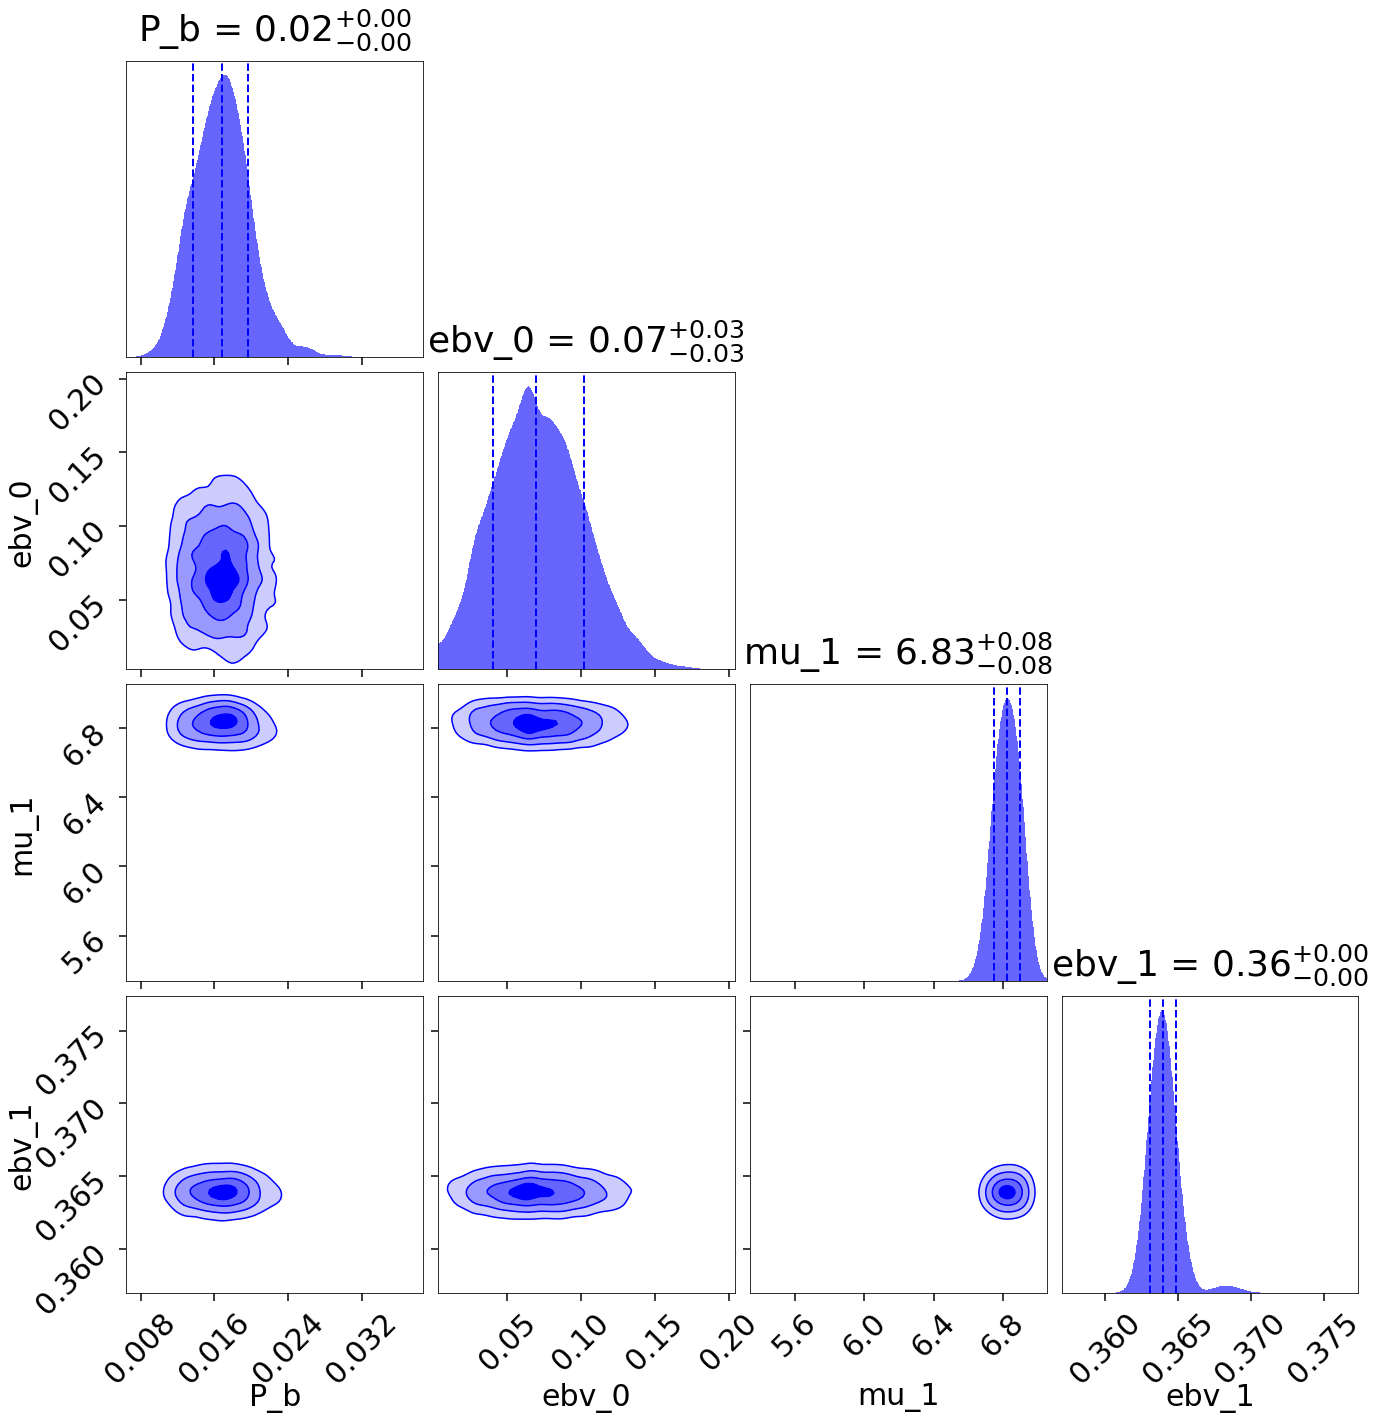

In [26]:
fig, ax = dyplot.cornerplot(results_mist, labels=['P_b', 'ebv_0', 'mu_1', 'ebv_1'],
                            show_titles=True, title_kwargs={'y': 1.05}, color='blue',
                            fig=plt.subplots(4, 4, figsize=(20, 20)))